# Задание

### Приблизить стационарный и нестационарный ряд моделями МА

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

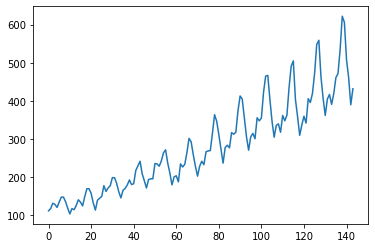

In [78]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
series = airlines_passengers["Count"]
series.plot();

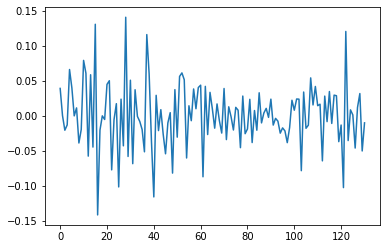

In [79]:
series2 = boxcox(series, 0) # нормализуем дисперсию
series2 = np.diff(series2, 1) # уберем тренд
series2 = series2[12:] - series2[:-12] # уберем сезонность с лагом 12
plt.plot(series2);

In [30]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [31]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [32]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [33]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [46]:
train, test = series[:100],series[100:]

In [47]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [92]:
opt = minimize(mse, x0=[0.3,0.3,0.8], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [93]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 445.89198059231114
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.82121027e-05, -9.66338121e-05, -1.61765995e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 26
     njev: 39
   status: 0
  success: True
        x: array([0.35367319, 0.28079377, 1.        ])


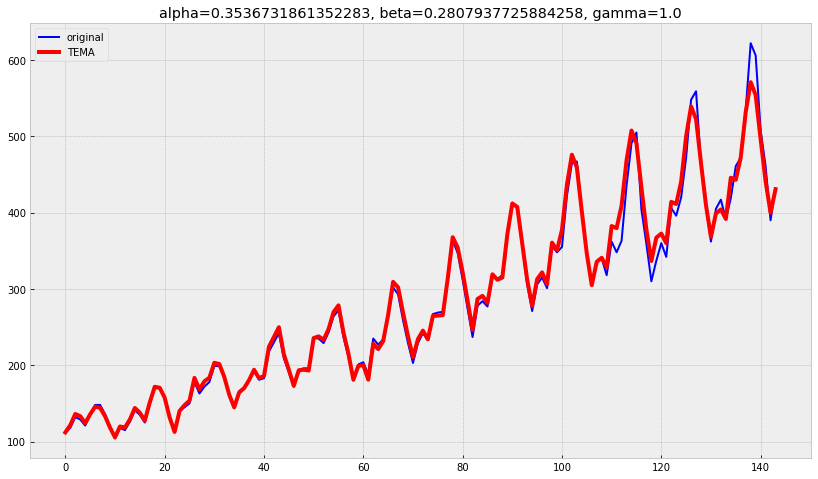

In [94]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

In [95]:
mse(opt.x)

445.89198059231114

In [112]:
train2, test2 = series2[:100],series2[100:]

In [154]:
def mse2(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train2, 12, alpha, beta, gamma, len(test2))
    predictions = result[-len(test2):]
    error = mean_squared_error(predictions, test2)
    return error

In [182]:
opt2 = minimize(mse2, x0=[0.5,0.5,0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [183]:
alpha_opt2, beta_opt2, gamma_opt2 = opt2.x

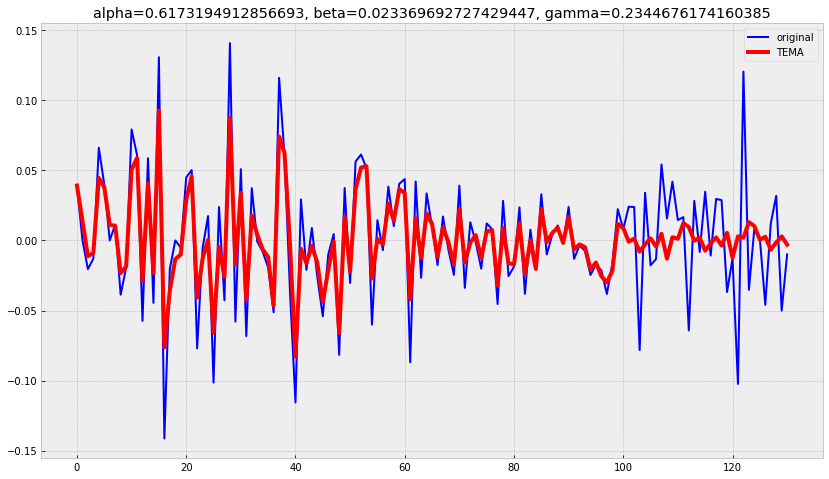

In [184]:
plot_tema(alpha_opt2, beta_opt2, gamma_opt2, ser=train2, ser_to_plot=series2, n_preds=len(test2))

In [185]:
mse2(opt2.x)

0.001898323988958577